In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer
from scipy.stats import shapiro
import scipy.stats as stats



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
files_path = '/content/drive/MyDrive/ColabNotebooks/Datasets/'
df = pd.read_csv(files_path + 'HBN.csv')
dict_df = pd.read_csv(files_path + 'data_dictionary.csv')


In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'Enrol_Season', 'Age', 'Sex', 'CGAS-Season',
       'CGAS-Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'FE-Season', 'FE-Max_Stage', 'FE-Time_Mins', 'FE-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
   

In [7]:
dict_df[dict_df['نام ستون'] == 'Sex']

,حوزه,نام ستون,توضیحات به انگلیسی,توضیحات,نوع,مقادیر,برچسب‌های مقادیر
3,Demographics,Sex,Sex of participant,جنسیت شرکت‌کننده,categorical int,"0,1","0=Male, 1=Female"


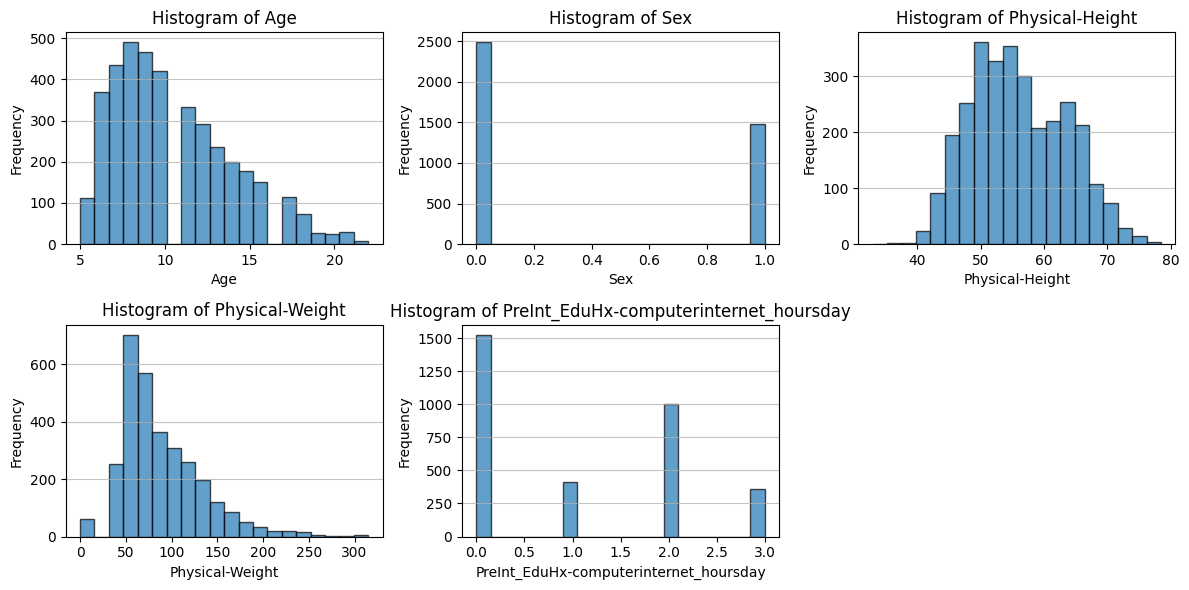

In [6]:
# توزیع اطلاعات شرکت کنندگان(سن، وزن، قد، جنسیت و میزان مصرف اینترنت) را رسم نمایید.


columns_hist_list = ['Age', 'Sex', 'Physical-Height', 'Physical-Weight', 'PreInt_EduHx-computerinternet_hoursday']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Adjust size

axes = axes.flatten()  # Flatten axes array for easy iteration

for i, col in enumerate(columns_hist_list):
    if col in df.columns:
        axes[i].hist(df[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Histogram of {col}')
        axes[i].grid(axis='y', alpha=0.75)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


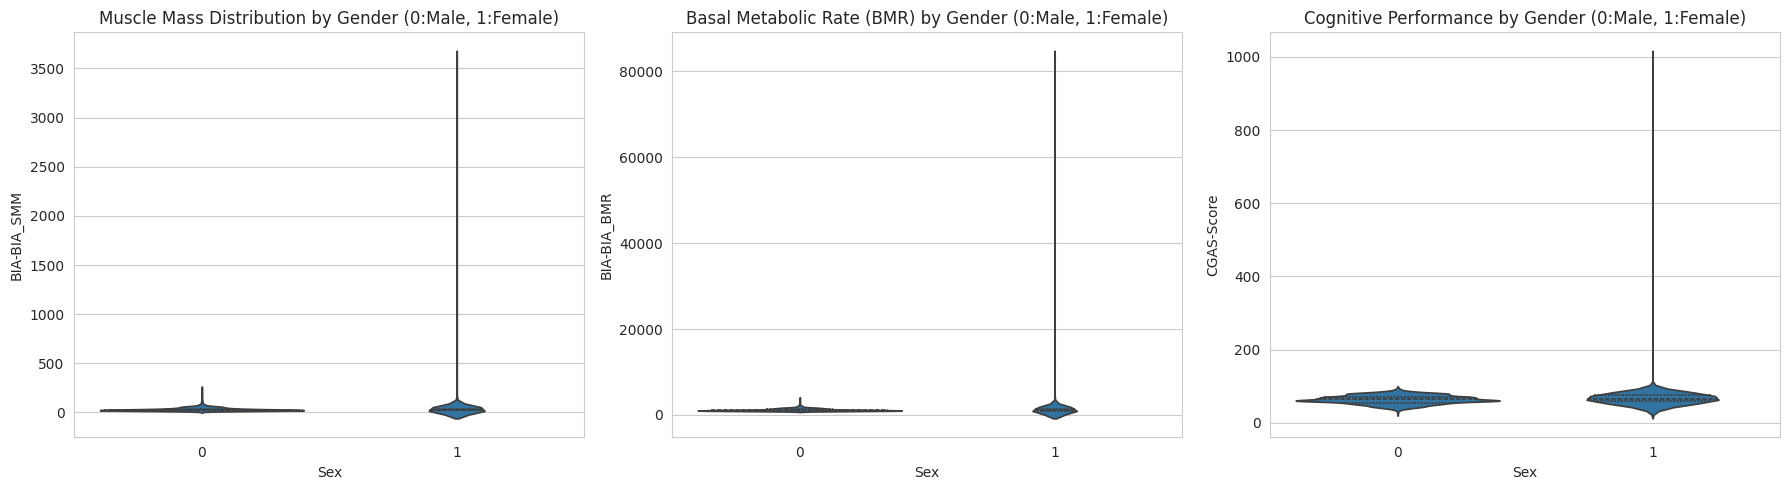

In [8]:
#توزیع توده‌ی عضلانی، نرخ متابولیسم پایه و میزان عملکرد ذهنی را بر حسب جنسیت رسم کنید.

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Violin Plot
sns.violinplot(x="Sex", y="BIA-BIA_SMM", data=df, ax=axes[0], inner="quartile")
axes[0].set_title("Muscle Mass Distribution by Gender (0:Male, 1:Female)")

sns.violinplot(x="Sex", y="BIA-BIA_BMR", data=df, ax=axes[1], inner="quartile")
axes[1].set_title("Basal Metabolic Rate (BMR) by Gender (0:Male, 1:Female)")

sns.violinplot(x="Sex", y="CGAS-Score", data=df, ax=axes[2], inner="quartile")
axes[2].set_title("Cognitive Performance by Gender (0:Male, 1:Female)")

plt.tight_layout()
plt.show()


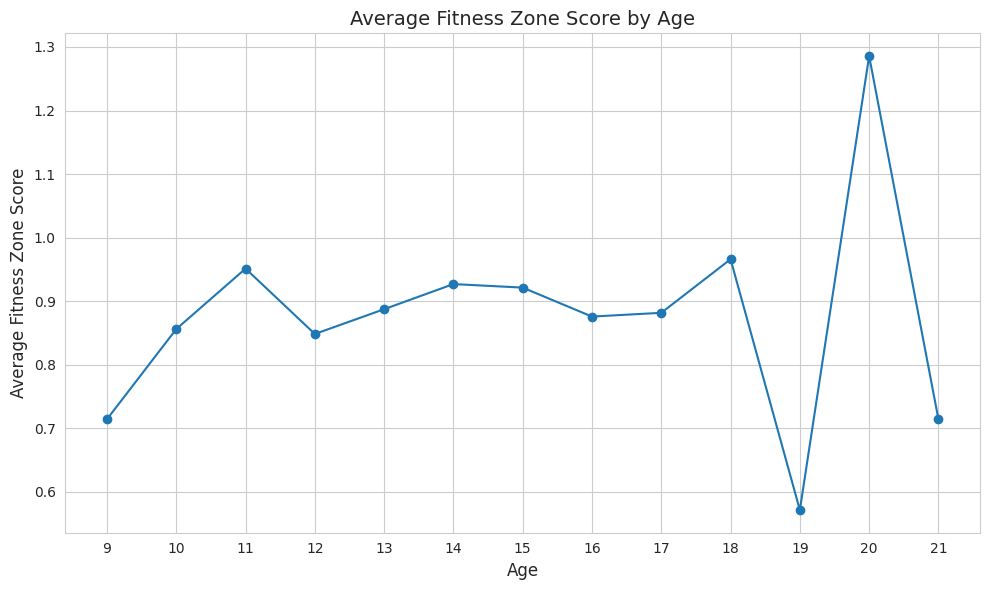

In [11]:
# توزیع میانگین میزان تناسب در تست آمادگی جسمانی را بر حسب سن رسم کنید.

fitness_columns = [
    "FGC-FGC_CU_Zone", "FGC-FGC_GSND_Zone", "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU_Zone", "FGC-FGC_SRL_Zone", "FGC-FGC_SRR_Zone",
    "FGC-FGC_TL_Zone", "Age"
]

fitness_data = df[fitness_columns].dropna()

# Calculate the mean fitness zone per age
fitness_data["Fitness_Mean"] = fitness_data[fitness_columns[:-1]].mean(axis=1)
age_fitness_mean = fitness_data.groupby("Age")["Fitness_Mean"].mean()

plt.figure(figsize=(10, 6))
plt.plot(age_fitness_mean.index, age_fitness_mean.values, marker='o', linestyle='-')
plt.title("Average Fitness Zone Score by Age", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Average Fitness Zone Score", fontsize=12)
plt.grid(True)
plt.xticks(range(int(fitness_data["Age"].min()), int(fitness_data["Age"].max()) + 1))
plt.tight_layout()
plt.show()


In [9]:
missing_list = []
for id in df['id']:
    try:
        parquet = pd.read_parquet(files_path + f'series.parquet//id={id}', engine='pyarrow')
        mean_light = parquet.aggregate({
          'light': 'mean'

        })
        # filtered the data -> weared the wristband and had movement
        steps_count = len(parquet[(parquet['non-wear_flag'] == 0) & (parquet['enmo'] != 0)])
        # number of steps, mean light that our case had exposed to
        df.loc[df['id'] == id, 'mean_light'] = mean_light.loc['light']
        df.loc[df['id'] == id, 'steps_count'] = steps_count
    except:
        missing_list.append(id)
print(len(missing_list))


2964


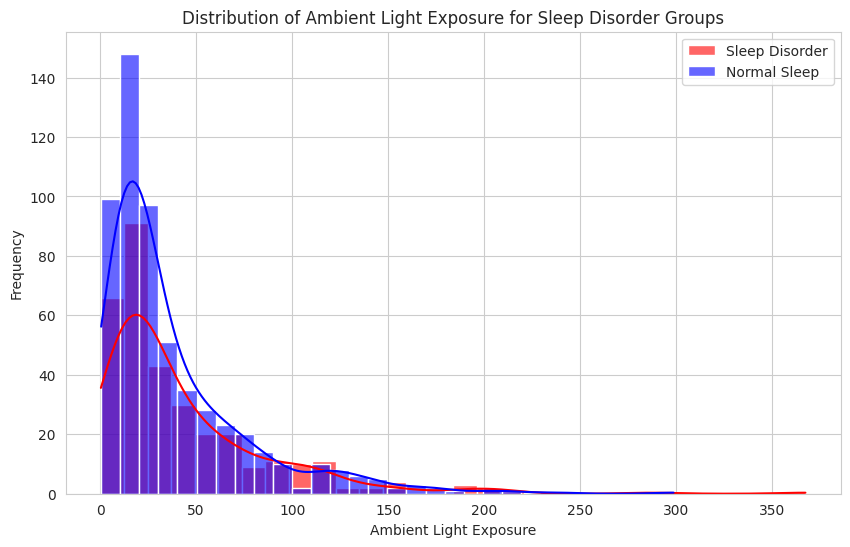

In [12]:
# Q4
# افراد را بر اساس نمره‌ی T اختلالات خواب به دو دسته تقسیم کنید: دسته‌ی با نمره‌ی T زیر پنجاه را بدون اختلال خواب و دسته‌ی بالای ۵۰ را دارای اختلال خواب در نظر بگیرید؛ توزیع میانگین نور محیطی در طول روز را برای این دو دسته نمایش دهید.
cases_with_sleep_disorders = df[(df['SDS-SDS_Total_T'] <= 50) & (pd.notna(df['mean_light']))]
cases_with_normal_sleep = df[(df['SDS-SDS_Total_T'] > 50) & (pd.notna(df['mean_light']))]

plt.figure(figsize=(10, 6))
sns.histplot(cases_with_sleep_disorders['mean_light'], color='red', label='Sleep Disorder', kde=True, bins=30, alpha=0.6)
sns.histplot(cases_with_normal_sleep['mean_light'], color='blue', label='Normal Sleep', kde=True, bins=30, alpha=0.6)

# Labels and title
plt.xlabel("Ambient Light Exposure")
plt.ylabel("Frequency")
plt.title("Distribution of Ambient Light Exposure for Sleep Disorder Groups")
plt.legend()
plt.show()

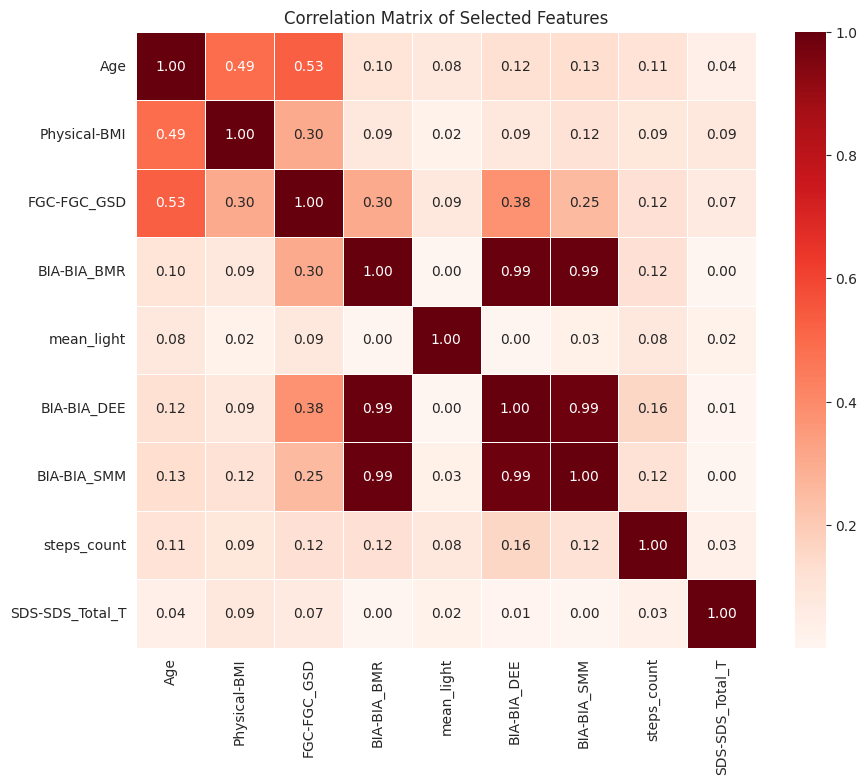

In [13]:
#  ماتریس هم‌بستگی را برای سن، شاخص توده‌ی بدنی، تست قدرت با دست غالب، نرخ متابولیسم پایه، میانگین نور محیطی در روز، مصرف انرژی روزانه، توده‌ی عضله‌ی خالص، میانگین تعداد گام در یک روز و نمره‌ی T اختلال خواب رسم کنید.

required_columns = [
    "Age",  # سن
    "Physical-BMI",  # شاخص توده‌ی بدنی
    "FGC-FGC_GSD",  # تست قدرت با دست غالب
    "BIA-BIA_BMR",  # نرخ متابولیسم پایه
    "mean_light",  # میانگین نور محیطی در روز
    "BIA-BIA_DEE",  # مصرف انرژی روزانه
    "BIA-BIA_SMM",  # توده‌ی عضله‌ی خالص
    "steps_count",  #  تعداد گام در یک روز
    "SDS-SDS_Total_T"  # نمره‌ی T اختلال خواب
]

# correlation matrix
correlation_matrix = df[required_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(abs(correlation_matrix), annot=True, cmap="Reds", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Selected Features")
plt.show()

In [ ]:
df.head()

,Unnamed: 0,id,Enrol_Season,Age,Sex,CGAS-Season,CGAS-Score,Physical-Season,Physical-BMI,Physical-Height,...,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,mean_light,steps_count
0,0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,...,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN
1,1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,...,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN
2,2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,...,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN
3,3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,...,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,42.29631,40759.0
4,4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Q6
weekly_steps_df = pd.DataFrame(columns=["weekday", "steps_count"])
seasonal_steps_df = pd.DataFrame(columns=["quarter", "steps_count"])


for id in df['id']:
    if id in missing_list:
      continue
    else:
        parquet = pd.read_parquet(files_path + f'series.parquet//id={id}', engine='pyarrow')
        valid_steps = parquet[(parquet['enmo'] != 0) & (parquet['non-wear_flag'] == 0)]
        steps_per_day = valid_steps.groupby("weekday").size().reset_index(name="steps_count")
        steps_per_season = valid_steps.groupby("quarter").size().reset_index(name="steps_count")
    weekly_steps_df = pd.concat([weekly_steps_df, steps_per_day], ignore_index=True)
    seasonal_steps_df = pd.concat([seasonal_steps_df, steps_per_season], ignore_index=True)

final_weekly_steps = weekly_steps_df.groupby("weekday")["steps_count"].sum().reset_index()
final_seasonal_steps = seasonal_steps_df.groupby("quarter")["steps_count"].mean().reset_index()

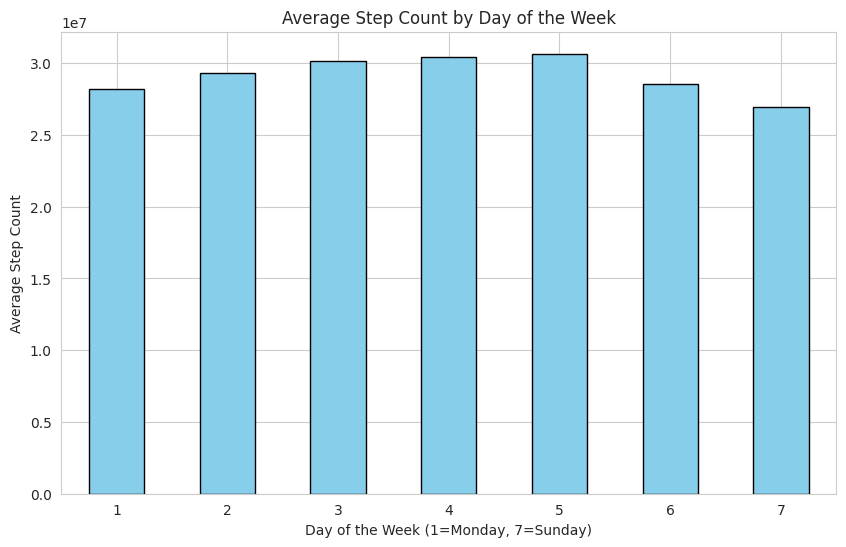

In [19]:
# ابتدا توزیع تعداد گام‌ها به تفکیک روز هفته را رسم کنید. سپس میانگین این مقدار را برای فصل‌های مختلف رسم کنید.

bar_data = final_weekly_steps.groupby('weekday')['steps_count'].mean()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_data.plot(kind='bar', color="skyblue", edgecolor="black")
plt.xlabel("Day of the Week (1=Monday, 7=Sunday)")
plt.ylabel("Average Step Count")
plt.title("Average Step Count by Day of the Week")
plt.xticks(ticks=range(0, len(bar_data)), labels=bar_data.index, rotation=0)
plt.show()

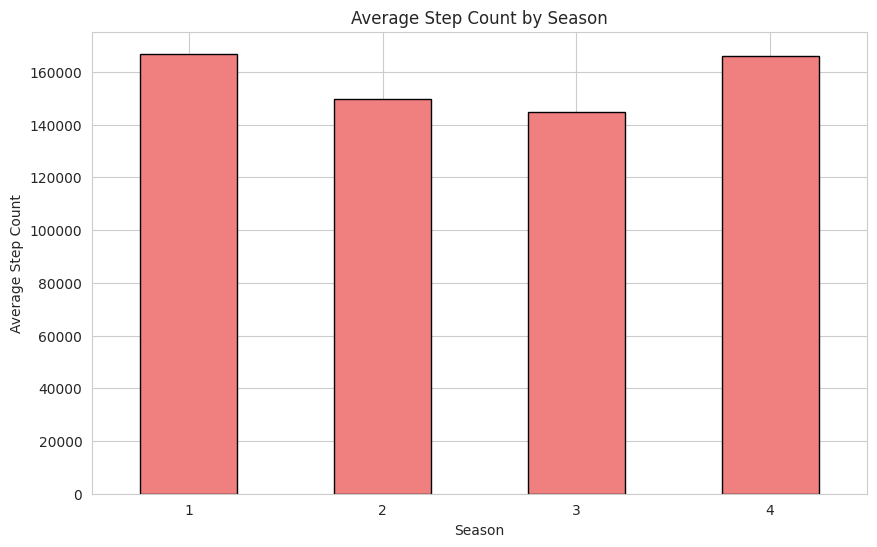

In [20]:
bar_data_seasonal = final_seasonal_steps.groupby('quarter')['steps_count'].mean()

plt.figure(figsize=(10, 6))
bar_data_seasonal.plot(kind='bar', color="lightcoral", edgecolor="black")
plt.xlabel("Season")
plt.ylabel("Average Step Count")
plt.title("Average Step Count by Season")
plt.xticks(ticks=range(0, len(bar_data_seasonal)), labels=bar_data_seasonal.index, rotation=0)
plt.show()

### Hypothesis Test

In [21]:
import scipy.stats as stats

cases_with_sleep_disorders = df[df['SDS-SDS_Total_T'] > 50]
cases_with_normal_sleep = df[df['SDS-SDS_Total_T'] <= 50]


<ipython-input-25-4f53e86b18c9>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bmr_disorders, bmr_normal], labels=['cases_with_sleep_disorders', 'cases_with_normal_sleep'])


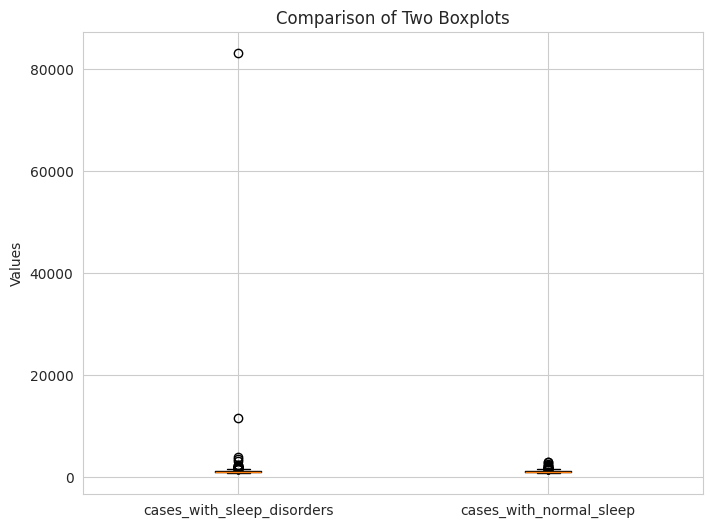

In [25]:
bmr_disorders = cases_with_sleep_disorders['BIA-BIA_BMR'].dropna()
bmr_normal = cases_with_normal_sleep['BIA-BIA_BMR'].dropna()

plt.figure(figsize=(8, 6))
plt.boxplot([bmr_disorders, bmr_normal], labels=['cases_with_sleep_disorders', 'cases_with_normal_sleep'])

plt.title("Comparison of Two Boxplots")
plt.ylabel("Values")

plt.show()

In [26]:
bmr_disorders_df = pd.DataFrame(bmr_disorders)
bmr_normal_df = pd.DataFrame(bmr_normal)

In [27]:
# outliers handling using IsolationForest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42,
    max_samples=0.7
)
feature_column = bmr_disorders_df[['BIA-BIA_BMR']]
bmr_disorders_df['outliers'] = iso_forest.fit_predict(feature_column)

feature_column = bmr_normal_df[['BIA-BIA_BMR']]
bmr_normal_df['outliers'] = iso_forest.fit_predict(feature_column)

# -1 indicates an outlier, 1 indicates an inlier

In [28]:
bmr_disorders_df_mv_handled = bmr_disorders_df[bmr_disorders_df['outliers'] == 1] # 11 outliers filtered
bmr_normal_df_mv_handled = bmr_normal_df[bmr_normal_df['outliers'] == 1] # 6 outliers filtered

<ipython-input-29-e9948cc0ee96>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bmr_disorders_df_mv_handled['BIA-BIA_BMR'], bmr_normal_df_mv_handled['BIA-BIA_BMR']], labels=['cases_with_sleep_disorders', 'cases_with_normal_sleep'])


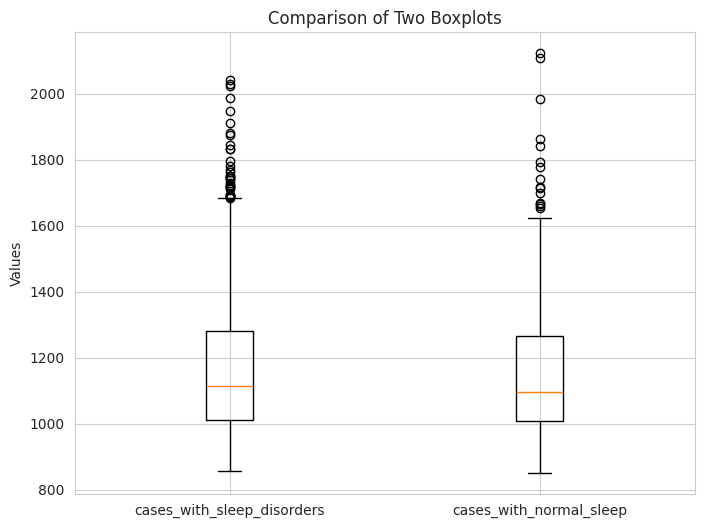

In [29]:
plt.figure(figsize=(8, 6))
plt.boxplot([bmr_disorders_df_mv_handled['BIA-BIA_BMR'], bmr_normal_df_mv_handled['BIA-BIA_BMR']], labels=['cases_with_sleep_disorders', 'cases_with_normal_sleep'])

plt.title("Comparison of Two Boxplots")
plt.ylabel("Values")

plt.show()

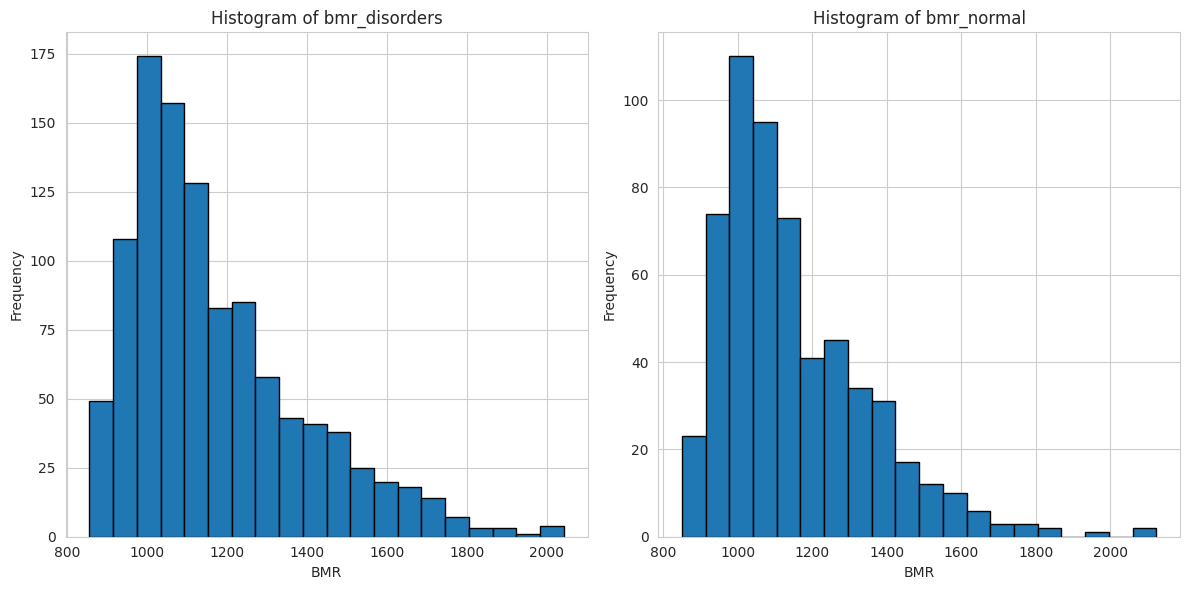

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(bmr_disorders_df_mv_handled['BIA-BIA_BMR'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of bmr_disorders')
axes[0].set_xlabel('BMR')
axes[0].set_ylabel('Frequency')

axes[1].hist(bmr_normal_df_mv_handled['BIA-BIA_BMR'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of bmr_normal')
axes[1].set_xlabel('BMR')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [31]:
# Power Transformation
transformer = PowerTransformer(method='box-cox')
bmr_disorders_df_mv_handled['BIA-BIA_BMR_transformed'] = transformer.fit_transform(bmr_disorders_df_mv_handled[['BIA-BIA_BMR']])
bmr_normal_df_mv_handled['BIA-BIA_BMR_transformed'] = transformer.fit_transform(bmr_normal_df_mv_handled[['BIA-BIA_BMR']])

<ipython-input-31-15e7e538998b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmr_disorders_df_mv_handled['BIA-BIA_BMR_transformed'] = transformer.fit_transform(bmr_disorders_df_mv_handled[['BIA-BIA_BMR']])
<ipython-input-31-15e7e538998b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmr_normal_df_mv_handled['BIA-BIA_BMR_transformed'] = transformer.fit_transform(bmr_normal_df_mv_handled[['BIA-BIA_BMR']])


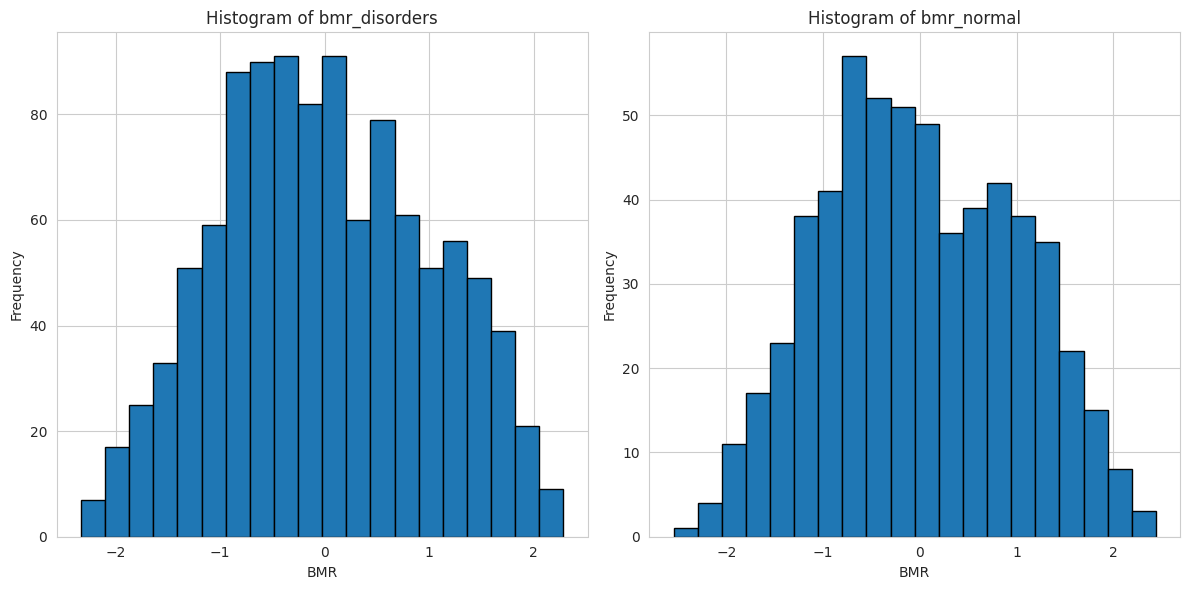

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(bmr_disorders_df_mv_handled['BIA-BIA_BMR_transformed'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of bmr_disorders')
axes[0].set_xlabel('BMR')
axes[0].set_ylabel('Frequency')

axes[1].hist(bmr_normal_df_mv_handled['BIA-BIA_BMR_transformed'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of bmr_normal')
axes[1].set_xlabel('BMR')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [33]:

stat, p = shapiro(bmr_disorders_df_mv_handled['BIA-BIA_BMR_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

stat, p = shapiro(bmr_normal_df_mv_handled['BIA-BIA_BMR_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

Statistic: 0.9864632697915184, p-value: 2.4818871108954097e-08
داده‌ها نرمال نیستند (فرض صفر رد می‌شود).
Statistic: 0.9876596058820605, p-value: 7.950573239244836e-05
داده‌ها نرمال نیستند (فرض صفر رد می‌شود).


In [34]:
# اختلالات خواب می‌تواند منجر به کاهش نرخ متابولیسم بدن شود.
# مشابه سوال ۵ قسمت توصیفی افراد را به دو دسته‌ی با اختلال خواب و بدون اختلال خواب تقسیم کنید، به نظر شما میانگین نرخ متابولیسم این دو گروه با هم برابر است؟

u_statistic, p_value = stats.mannwhitneyu(bmr_disorders_df_mv_handled['BIA-BIA_BMR_transformed'], bmr_normal_df_mv_handled['BIA-BIA_BMR_transformed'], alternative='two-sided')
print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("توزیع دو گروه متفاوت میباشد")
else:
    print("توزیع دو گروه از یک جنس میباشد")

U-statistic: 308252.0
P-value: 0.9928322517067921
توزیع دو گروه از یک جنس میباشد


In [35]:
# آیا به طور میانگین تفاوت مشهودی بین توده‌ی عضلانی خالص در دختران و پسران وجود دارد؟
# شرکت کنندگان را به دو دسته‌ی کودک (از ۵ تا ۱۳ سال) و جوان (از ۱۴ تا ۲۲ سال) تقسیم کنید، آیا به طور میانگین تفاوت مشهودی در توده‌ی عضلانی خالص کودکان و جوانان وجود دارد؟

male_muscle_mass = df[df['Sex'] == 1]['BIA-BIA_SMM'].dropna()
female_muscle_mass = df[df['Sex'] == 0]['BIA-BIA_SMM'].dropna()




<ipython-input-36-362e933f57d4>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([male_muscle_mass, female_muscle_mass], labels=['male_muscle_mass', 'female_muscle_mass'])


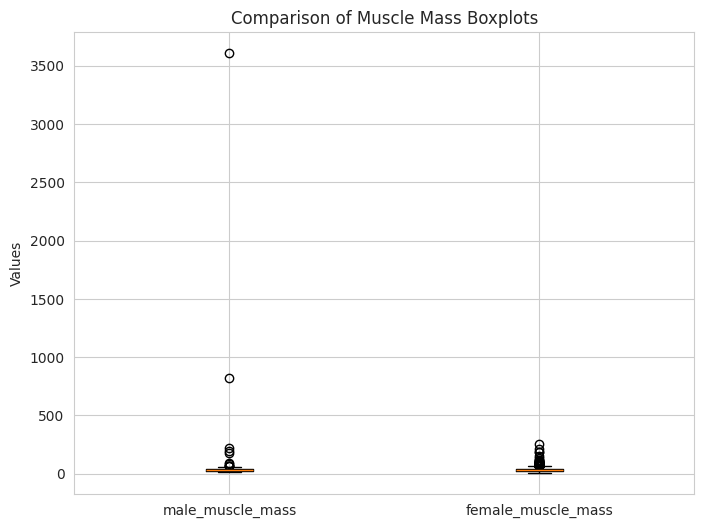

In [36]:
# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([male_muscle_mass, female_muscle_mass], labels=['male_muscle_mass', 'female_muscle_mass'])

plt.title("Comparison of Muscle Mass Boxplots")
plt.ylabel("Values")

plt.show()

In [37]:
female_muscle_mass_df = pd.DataFrame(female_muscle_mass)
male_muscle_mass_df = pd.DataFrame(male_muscle_mass)


In [38]:
# Outlier Handling
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42,
    max_samples=0.7
)
feature_column = female_muscle_mass_df[['BIA-BIA_SMM']]
female_muscle_mass_df['outliers'] = iso_forest.fit_predict(feature_column)

feature_column = male_muscle_mass_df[['BIA-BIA_SMM']]
male_muscle_mass_df['outliers'] = iso_forest.fit_predict(feature_column)

In [39]:
male_muscle_mass_df_ol_handled = male_muscle_mass_df[male_muscle_mass_df['outliers'] == 1] # 8 outliers
female_muscle_mass_df_ol_handled = female_muscle_mass_df[female_muscle_mass_df['outliers'] == 1] # 13 outliers

<ipython-input-40-3eccfe103b00>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([male_muscle_mass_df_ol_handled['BIA-BIA_SMM'], female_muscle_mass_df_ol_handled['BIA-BIA_SMM']], labels=['male_muscle_mass', 'female_muscle_mass'])


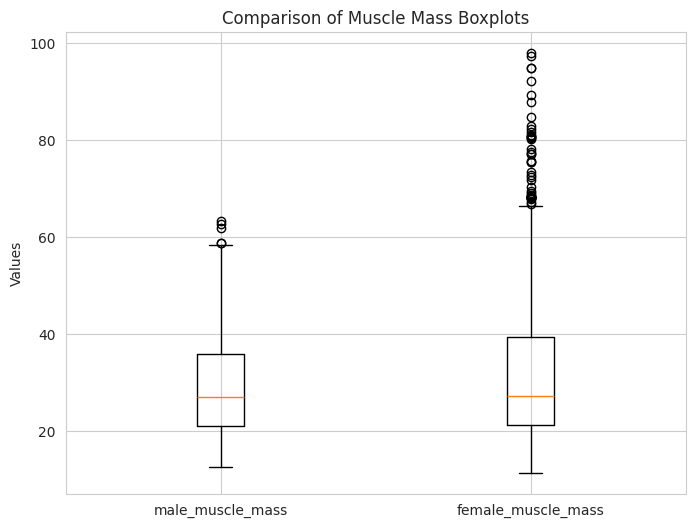

In [40]:
# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([male_muscle_mass_df_ol_handled['BIA-BIA_SMM'], female_muscle_mass_df_ol_handled['BIA-BIA_SMM']], labels=['male_muscle_mass', 'female_muscle_mass'])

plt.title("Comparison of Muscle Mass Boxplots")
plt.ylabel("Values")

plt.show()

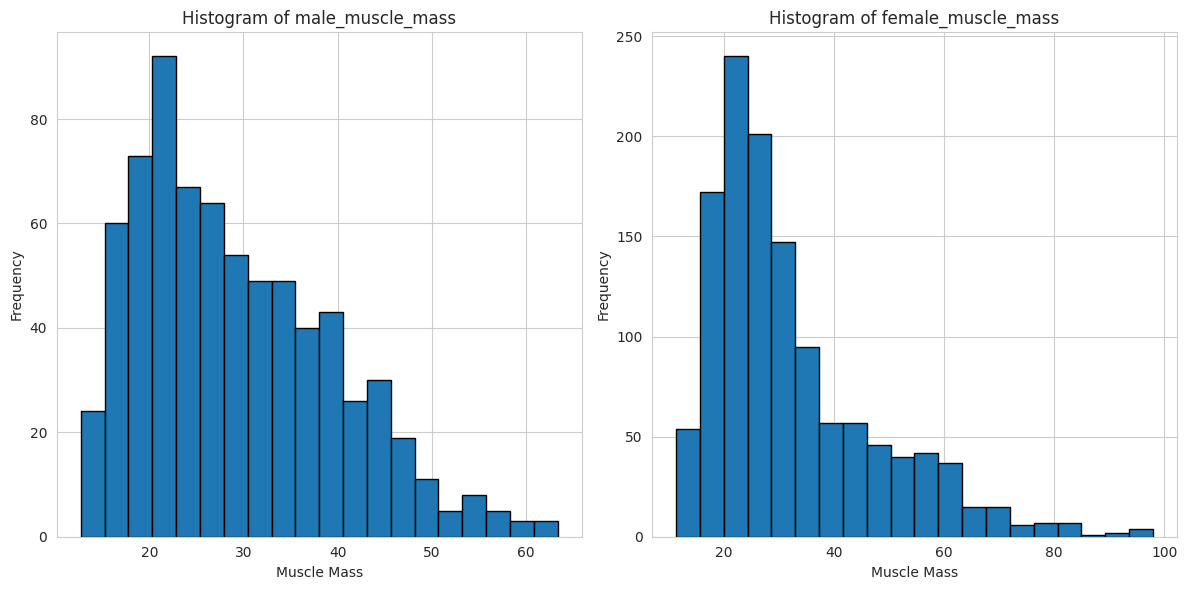

In [41]:
# Histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(male_muscle_mass_df_ol_handled['BIA-BIA_SMM'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of male_muscle_mass')
axes[0].set_xlabel('Muscle Mass')
axes[0].set_ylabel('Frequency')

axes[1].hist(female_muscle_mass_df_ol_handled['BIA-BIA_SMM'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of female_muscle_mass')
axes[1].set_xlabel('Muscle Mass')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [42]:
# Power Transformation
male_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(male_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])
female_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(female_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])

<ipython-input-42-040d3e08700e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(male_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])
<ipython-input-42-040d3e08700e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(female_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])


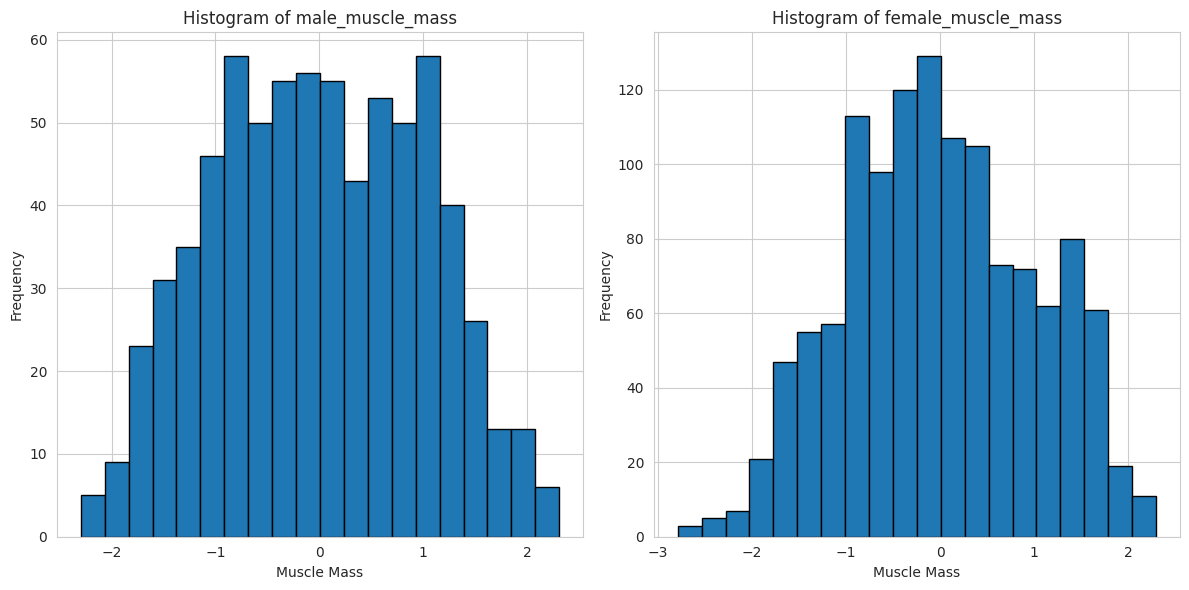

In [43]:
# Histogram after power transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(male_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of male_muscle_mass')
axes[0].set_xlabel('Muscle Mass')
axes[0].set_ylabel('Frequency')

axes[1].hist(female_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of female_muscle_mass')
axes[1].set_xlabel('Muscle Mass')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [44]:

stat, p = shapiro(male_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

stat, p = shapiro(female_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

Statistic: 0.9855068348160074, p-value: 1.353048205355964e-06
داده‌ها نرمال نیستند (فرض صفر رد می‌شود).
Statistic: 0.9887183744419439, p-value: 3.31056089371745e-08
داده‌ها نرمال نیستند (فرض صفر رد می‌شود).


In [45]:
# آیا به طور میانگین تفاوت مشهودی بین توده‌ی عضلانی خالص در دختران و پسران وجود دارد؟
u_stat_gender, p_value_gender = stats.mannwhitneyu(male_muscle_mass, female_muscle_mass, alternative='two-sided')

if p_value < 0.05:
    print("توزیع دو گروه متفاوت میباشد")
else:
    print("توزیع دو گروه از یک جنس میباشد")


توزیع دو گروه از یک جنس میباشد


In [46]:
# شرکت کنندگان را به دو دسته‌ی کودک (از ۵ تا ۱۳ سال) و جوان (از ۱۴ تا ۲۲ سال) تقسیم کنید، آیا به طور میانگین تفاوت مشهودی در توده‌ی عضلانی خالص کودکان و جوانان وجود دارد؟

# Splitting by age group for lean muscle mass comparison
df['Age_Group'] = pd.cut(df['Age'], bins=[4, 13, 22], labels=['Child', 'Young Adult'])
child_muscle_mass_df = pd.DataFrame(df[df['Age_Group'] == 'Child']['BIA-BIA_SMM'].dropna())
young_adult_muscle_mass_df = pd.DataFrame(df[df['Age_Group'] == 'Young Adult']['BIA-BIA_SMM'].dropna())


<ipython-input-47-9668f15f1c38>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([young_adult_muscle_mass_df['BIA-BIA_SMM'], child_muscle_mass_df['BIA-BIA_SMM']], labels=['young_adult_muscle_mass', 'child_muscle_mass'])


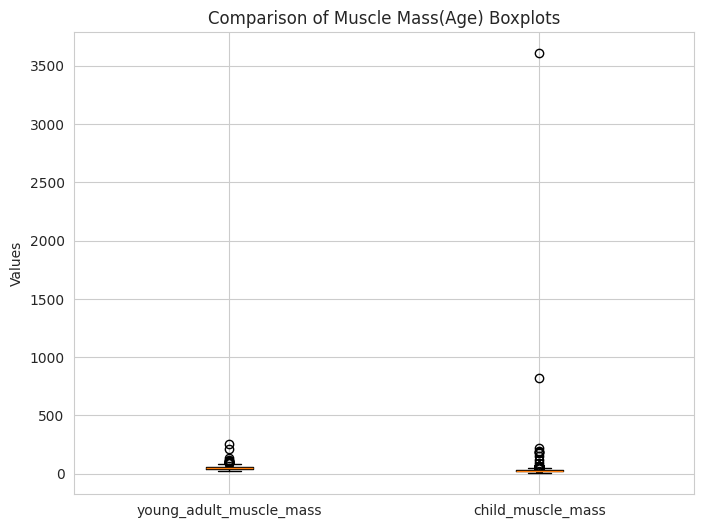

In [47]:
# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([young_adult_muscle_mass_df['BIA-BIA_SMM'], child_muscle_mass_df['BIA-BIA_SMM']], labels=['young_adult_muscle_mass', 'child_muscle_mass'])

plt.title("Comparison of Muscle Mass(Age) Boxplots")
plt.ylabel("Values")

plt.show()

In [48]:
# Outlier Handling
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42,
    max_samples=0.7
)
feature_column = young_adult_muscle_mass_df[['BIA-BIA_SMM']]
young_adult_muscle_mass_df['outliers'] = iso_forest.fit_predict(feature_column)

feature_column = child_muscle_mass_df[['BIA-BIA_SMM']]
child_muscle_mass_df['outliers'] = iso_forest.fit_predict(feature_column)

In [49]:
young_adult_muscle_mass_df_ol_handled = young_adult_muscle_mass_df[young_adult_muscle_mass_df['outliers'] == 1] # 4 outliers
child_muscle_mass_df_ol_handled = child_muscle_mass_df[child_muscle_mass_df['outliers'] == 1] # 16 outliers

<ipython-input-50-8add821e97a4>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM'], child_muscle_mass_df_ol_handled['BIA-BIA_SMM']], labels=['young_adult_muscle_mass', 'child_muscle_mass'])


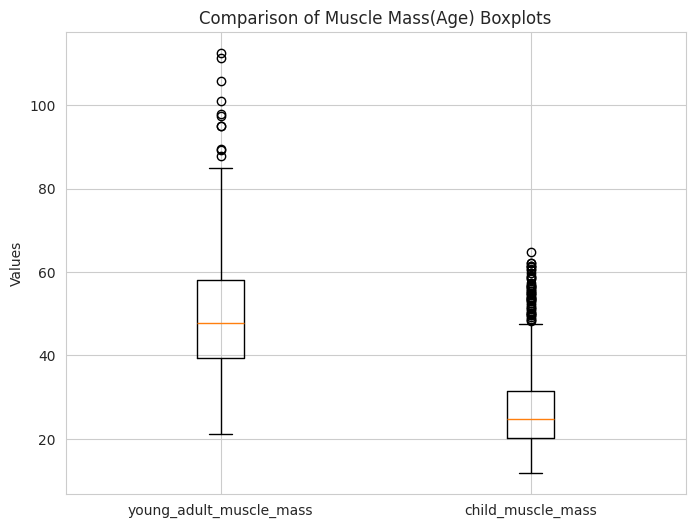

In [50]:
# Boxplot after outlier handling
plt.figure(figsize=(8, 6))
plt.boxplot([young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM'], child_muscle_mass_df_ol_handled['BIA-BIA_SMM']], labels=['young_adult_muscle_mass', 'child_muscle_mass'])

plt.title("Comparison of Muscle Mass(Age) Boxplots")
plt.ylabel("Values")

plt.show()

In [51]:
# Power Transformation
young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(young_adult_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])
child_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(child_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])

<ipython-input-51-0fa485bd7df8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(young_adult_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])
<ipython-input-51-0fa485bd7df8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'] = transformer.fit_transform(child_muscle_mass_df_ol_handled[['BIA-BIA_SMM']])


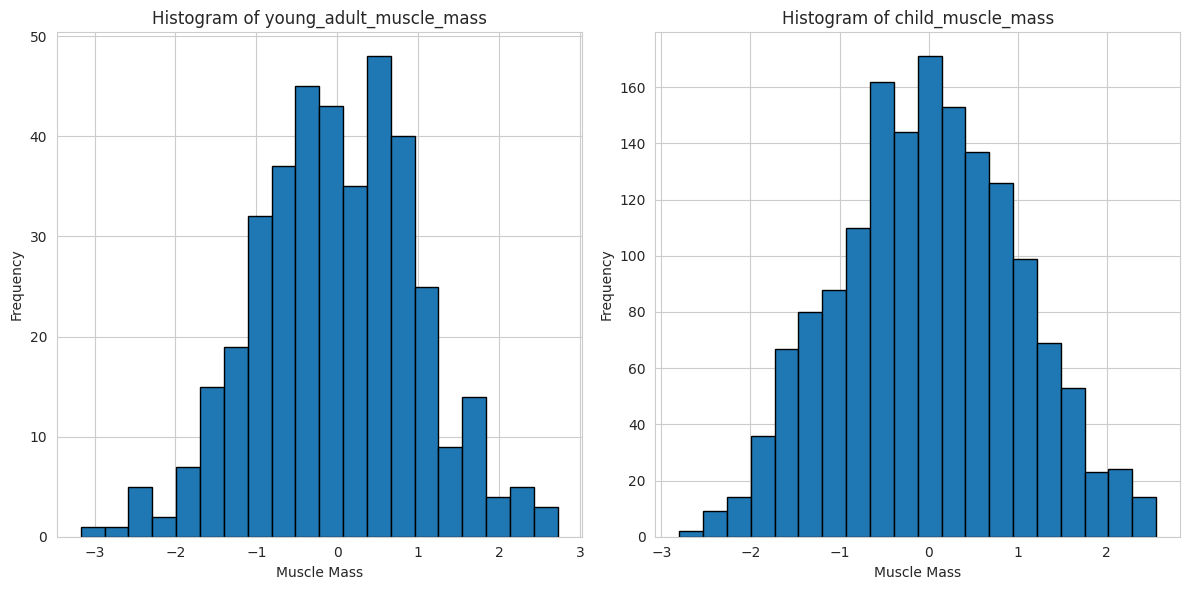

In [52]:
# Histogram after power transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of young_adult_muscle_mass')
axes[0].set_xlabel('Muscle Mass')
axes[0].set_ylabel('Frequency')

axes[1].hist(child_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of child_muscle_mass')
axes[1].set_xlabel('Muscle Mass')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [53]:
stat, p = shapiro(child_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

stat, p = shapiro(young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'])
print(f"Statistic: {stat}, p-value: {p}")

if p > 0.05:
    print("داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).")
else:
    print("داده‌ها نرمال نیستند (فرض صفر رد می‌شود).")

Statistic: 0.9964158932518223, p-value: 0.0009380112017547536
داده‌ها نرمال نیستند (فرض صفر رد می‌شود).
Statistic: 0.9979954202671782, p-value: 0.9287726268572517
داده‌ها از توزیع نرمال پیروی می‌کنند (فرض صفر رد نمی‌شود).


In [54]:
u_stat_age, p_value_age = stats.mannwhitneyu(child_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], young_adult_muscle_mass_df_ol_handled['BIA-BIA_SMM_transformed'], alternative='two-sided')

if p_value < 0.05:
    print("توزیع دو گروه متفاوت میباشد")
else:
    print("توزیع دو گروه از یک جنس میباشد")


توزیع دو گروه از یک جنس میباشد


In [55]:
# گزارهٔ زیر را نه تنها با استفاده از آزمون فرض، بلکه همراه با توضیحات و تحلیل‌های مناسب و بیشتر مورد بررسی قرار دهید.
# دانشمندان ادعا می‌کنند که
# میزان فعالیت بدنی در کودکان و بزرگسالانی که بیشتر از دو ساعت از اینترنت استفاده می‌کنند
# نسبت به کودکان و بزرگسالانی که کمتر از این مقدار از اینترنت استفاده می‌کنند، بیشتر است.

group_more_than_2h = df[df['PreInt_EduHx-computerinternet_hoursday'] > 2]
group_less_equal_2h = df[df['PreInt_EduHx-computerinternet_hoursday'] <= 2]

physical_activity_more = pd.concat([
    group_more_than_2h['PAQ_A-PAQ_A_Total'],  # Physical Activity Adults
    group_more_than_2h['PAQ_C-PAQ_C_Total']  # Physical Activity Children
]).dropna()

physical_activity_less = pd.concat([
    group_less_equal_2h['PAQ_A-PAQ_A_Total'],
    group_less_equal_2h['PAQ_C-PAQ_C_Total']
]).dropna()

<ipython-input-56-b8ac138c3891>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([physical_activity_more, physical_activity_less], labels=['physical_activity_more', 'physical_activity_less'])


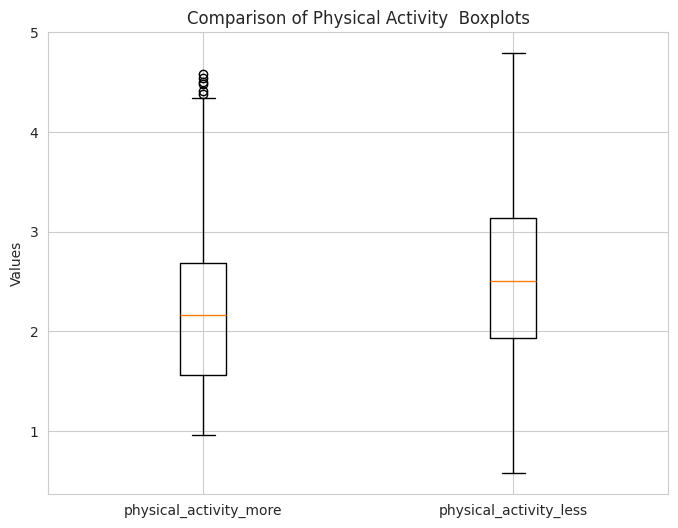

In [56]:
# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([physical_activity_more, physical_activity_less], labels=['physical_activity_more', 'physical_activity_less'])

plt.title("Comparison of Physical Activity  Boxplots")
plt.ylabel("Values")

plt.show()

In [58]:
shapiro_more = stats.shapiro(physical_activity_more)
shapiro_less = stats.shapiro(physical_activity_less)

print("Shapiro p_vlaue group_more_than_2h: ", shapiro_more.pvalue)
print("Shapiro p_vlaue group_less_than_2h: ", shapiro_less.pvalue)

if shapiro_more.pvalue > 0.05 and shapiro_less.pvalue > 0.05: # Both variables distribution is normal
    test_stat, p_value = stats.ttest_ind(physical_activity_more, physical_activity_less, equal_var=False)
    test_name = "Independent t-test"
else:
    test_stat, p_value = stats.mannwhitneyu(physical_activity_more, physical_activity_less, alternative='greater')
    test_name = "Mann-Whitney U Test"
print(test_name)
summary = pd.DataFrame({
    "Group": ["More than 2h Internet", "2h or Less Internet"],
    "Mean Activity": [physical_activity_more.mean(), physical_activity_less.mean()],
    "Median Activity": [physical_activity_more.median(), physical_activity_less.median()],
    "Sample Size": [len(physical_activity_more), len(physical_activity_less)]
})

print("P_value: ", p_value)

if p_value < 0.05:
    print("نتیجه: ادعای دانشمندان تأیید می‌شود. فعالیت بدنی در افرادی که بیش از ۲ ساعت از اینترنت استفاده می‌کنند بیشتر است.")
else:
    print("نتیجه: ادعای دانشمندان تأیید نمی‌شود. تفاوت معناداری در فعالیت بدنی بین این دو گروه مشاهده نشد.")

Shapiro p_vlaue group_more_than_2h:  3.9832345471680986e-07
Shapiro p_vlaue group_less_than_2h:  7.836364235307674e-10
Mann-Whitney U Test
P_value:  0.9999999997983069
نتیجه: ادعای دانشمندان تأیید نمی‌شود. تفاوت معناداری در فعالیت بدنی بین این دو گروه مشاهده نشد.


In [ ]:
summary

,Group,Mean Activity,Median Activity,Sample Size
0,More than 2h Internet,2.220947,2.17,262
1,2h or Less Internet,2.544485,2.51,1783


<div dir="rtl" style="text-align: right;">
    <h3>نتایج آزمون فرض</h3>
    <p><b>آزمون انجام شده:</b> Mann-Whitney U Test</p>
    <p><b> p-value:</b> 0.9999999998</p>
    <hr>
    <h3><b>تحلیل نتایج:</b></h3>
    <ol>
        <li><b>تفسیر p-value:</b>
            <ul>
                <li>مقدار p-value بسیار بزرگ‌تر از 0.05 است.</li>
                <li>این به این معناهستش که شواهد کافی برای رد فرض صفر (<i>H<sub>0</sub></i>) وجود نداره.</li>
                <li>فرض صفر هم این بود که دو گروه از توزیع یکسانی برخوردارند</li>
            </ul>
        </li>
</div>
